# MLServer - Retrieve and Classify

This notebook retrieves data from an Azure Function server, performs classification using a machine learning model and uploads the results back to the cloud.

All of that is performed using API REST endpoints exposed in Azure.

Segmentation model is DeepLabV3+, at https://github.com/bonlime/keras-deeplab-v3-plus

## Retrieving and Visualizing Next Task

In [1]:
import requests
import base64
from PIL import Image
import io

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

getnexttask_url = 'https://blobstorefuncteste.azurewebsites.net/api/getnexttask_v0?code=YCbRpKphpfyJR5Sa4oELsAaV4Zz6Pt8EdtasFt10zazr6ae3mQZapA=='

In [2]:
def get_next_task(url):
    r = requests.post(url, data={})
    split_data = r.text.split('|')
    return { 'task_id' : split_data[0], 'payload' : base64.b64decode(split_data[1]) }

next_task = get_next_task(getnexttask_url)
next_task['task_id']

'cc95049c-bc8a-47ad-a29f-79e374b4994b.payload'

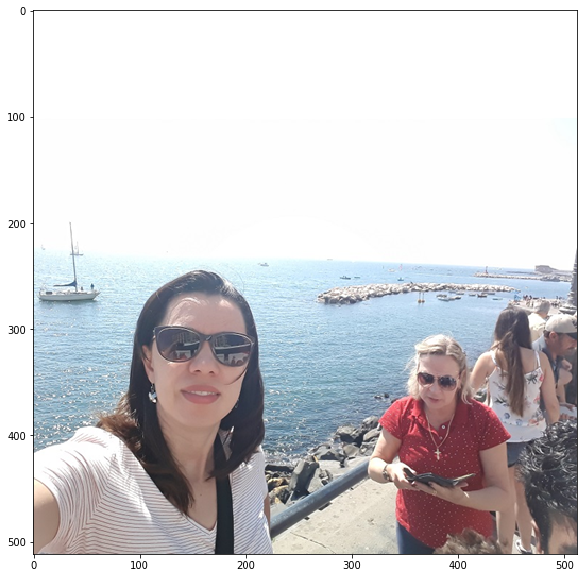

In [3]:
image_data = next_task['payload']
image = np.asarray(Image.open(io.BytesIO(image_data)))
plt.figure(figsize=(10,10))
plt.imshow(image)

## Retrieve Predictions

In [4]:
from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
from deepLab import Deeplabv3
deeplab_model = Deeplabv3()

label_names = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

Using TensorFlow backend.


In [5]:
img = image
w, h, _ = img.shape
ratio = 512. / np.max([w,h])
resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))[:,:,0:3]

pad_x = int(512 - resized.shape[0])
pad_y = int(512 - resized.shape[1])
resized2 = np.pad(resized,((0,pad_x),(0,pad_y),(0,0)),mode='constant')

img_resized = resized2
resized2 = resized2 / 127.5 - 1.

1/1 [==============================] - 2s 2s/step


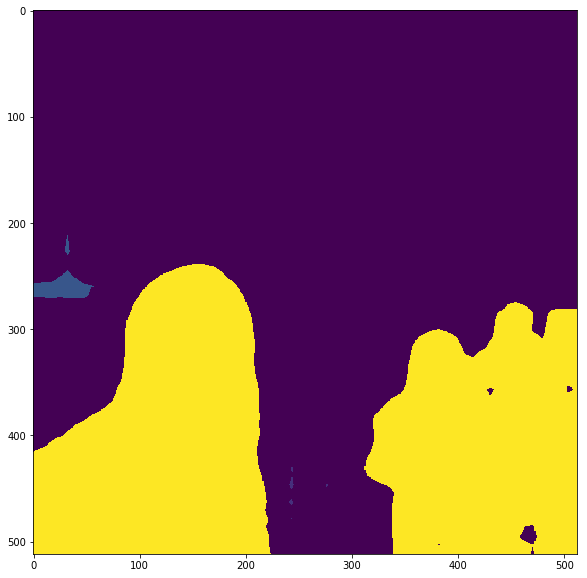

In [6]:
res = deeplab_model.predict(np.expand_dims(resized2,0), verbose=1)
labels = np.argmax(res.squeeze(),-1)
plt.figure(figsize=(10,10))
plt.imshow(labels)

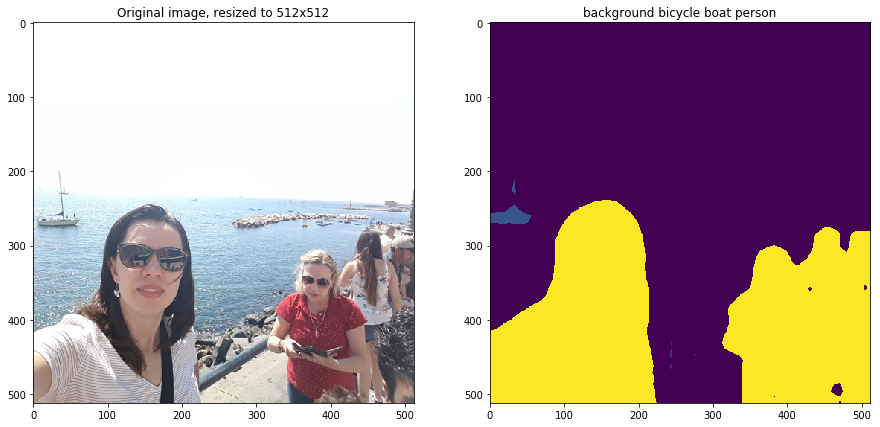

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original image, resized to 512x512')
plt.imshow(img_resized)
plt.subplot(1,2,2)
cur_labels = ' '.join(label_names[np.unique(labels)])
plt.title(cur_labels)
plt.imshow(labels)